# IMDB Movie Reviews
* Import Libraries

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split as tt
import warnings


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


* Reading the dataset 

In [16]:
df = pd.read_csv("/content/drive/MyDrive/IMDB Movie Reviews/IMDB Dataset.csv")

* Details about the dataset

In [17]:
print(df.shape)
print(df.info())
print(df.describe())
print(df["sentiment"].value_counts())

(50000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000
positive    25000
negative    25000
Name: sentiment, dtype: int64


* Label Mapping

In [18]:
ma = {1:"positive",0:"negative"}
df.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)

* Removing Duplicates 
*Resizing the dataset (Reduced the size of the dataset in order to reduce time taken to train and test the model)

In [19]:
df = df.drop_duplicates()
positive = df[df["sentiment"]==1]
negative = df[df["sentiment"]==0]
print(df.shape)
print(positive.shape)
print(negative.shape)
df = pd.concat([positive.iloc[:2500,],negative.iloc[:2500,]],axis=0)
print(df.shape)
print(df["sentiment"].value_counts())

(49582, 2)
(24884, 2)
(24698, 2)
(5000, 2)
1    2500
0    2500
Name: sentiment, dtype: int64


# Stemming the content using PorterStemmer

In [20]:
# Stemming
words = stopwords.words("english")

port_stem = PorterStemmer()

def stemming(contents):
    # Replacing anything that isn't an alphabet(text) with ' '
    stemmed_contents = re.sub(r'[^a-zA-Z]',' ',contents)
    # Converting entire text to lower
    stemmed_contents = stemmed_contents.lower()
    # Converting the text into a list of words
    stemmed_contents = stemmed_contents.split()
    # Removing stopwords
    stemmed_contents = [port_stem.stem(word) for word in stemmed_contents if word not in words]
    stemmed_contents = ' '.join(stemmed_contents)
    return stemmed_contents


df["review"] = df["review"].apply(stemming)

* Data Initialization

In [21]:
m = df["review"].values
print(m)
n = df["sentiment"]
print(n)

['one review mention watch oz episod hook right exactli happen br br first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word br br call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never far away br br would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort view that get touch d

# Vectorizing the data and Data Initialization


In [22]:
vectorizer = TfidfVectorizer()
m = vectorizer.fit_transform(m)
print(m)

  (0, 20768)	0.049854888661070955
  (0, 5459)	0.08161053649645977
  (0, 23413)	0.05030815306529995
  (0, 22995)	0.06895159969871603
  (0, 24796)	0.04466611201693401
  (0, 24000)	0.07425511188616897
  (0, 4462)	0.06828699578799698
  (0, 1881)	0.04105796037450682
  (0, 14188)	0.03997932820890231
  (0, 7607)	0.04836450302534791
  (0, 20964)	0.06251382545881469
  (0, 22067)	0.05838125836262803
  (0, 12706)	0.045865337586757815
  (0, 2248)	0.08292899330417172
  (0, 23774)	0.038438200655815685
  (0, 4175)	0.05590571335978201
  (0, 14587)	0.05483024992896447
  (0, 13921)	0.06122260210191008
  (0, 25275)	0.02716410684644975
  (0, 9051)	0.04987566410969833
  (0, 16290)	0.05254872068390733
  (0, 12391)	0.0418672129988242
  (0, 11351)	0.19335354017481626
  (0, 15696)	0.10175066545264179
  (0, 21321)	0.07425511188616897
  :	:
  (4999, 167)	0.02835232244169001
  (4999, 17260)	0.03869290157580522
  (4999, 23198)	0.061359656600609644
  (4999, 8051)	0.01638221149865178
  (4999, 13290)	0.02850569121690

* Splitting data for training and testing

In [23]:
m_train, m_test, n_train, n_test = tt(m,n,train_size=0.78,stratify=n,random_state=0)

* Different ML Models

In [24]:
models = [RandomForestClassifier(random_state=0), SVC(random_state=0),
          LogisticRegression(random_state=0), MLPClassifier(random_state=0)]

# Model Training and Testing

In [25]:
models_train_pred = [[],[],[],[]]
models_test_pred = [[],[],[],[]]

def model_fitting():
    for i in range(0,4):
        clf = models[i]
        clf.fit(m_train, n_train)
        
        # Results
        clf_train_pred = clf.predict(m_train)
        clf_test_pred = clf.predict(m_test)
        models_train_pred[i] = clf_test_pred
        models_test_pred[i] = clf_test_pred
        # Accuracy Score
        train_acc = accuracy_score(n_train, clf_train_pred)
        print("Training Accuracy for",models[i],":",train_acc)
        test_acc = accuracy_score(n_test, clf_test_pred)
        print("Testing Accuracy for",models[i],":",test_acc)
        print(" ")
        
model_fitting()

Training Accuracy for RandomForestClassifier(random_state=0) : 1.0
Testing Accuracy for RandomForestClassifier(random_state=0) : 0.82
 
Training Accuracy for SVC(random_state=0) : 0.997948717948718
Testing Accuracy for SVC(random_state=0) : 0.8554545454545455
 
Training Accuracy for LogisticRegression(random_state=0) : 0.9502564102564103
Testing Accuracy for LogisticRegression(random_state=0) : 0.8590909090909091
 
Training Accuracy for MLPClassifier(random_state=0) : 1.0
Testing Accuracy for MLPClassifier(random_state=0) : 0.84
 


# Confusion Matrices with heatmap

[[450 100]
 [ 98 452]]
Recall for RandomForestClassifier(random_state=0) : 0.8218181818181818
Precision for RandomForestClassifier(random_state=0) : 0.8188405797101449
F1 Score for RandomForestClassifier(random_state=0) : 0.8203266787658801


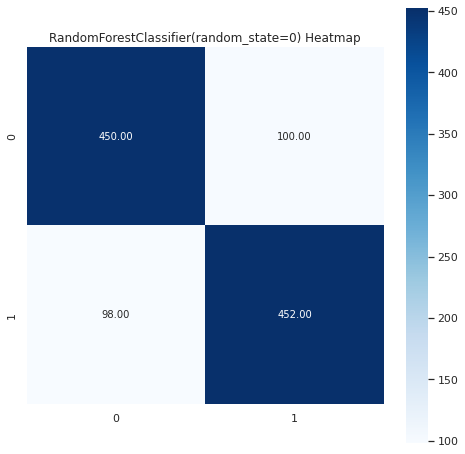

[[456  94]
 [ 65 485]]
Recall for SVC(random_state=0) : 0.8818181818181818
Precision for SVC(random_state=0) : 0.8376511226252159
F1 Score for SVC(random_state=0) : 0.8591674047829938


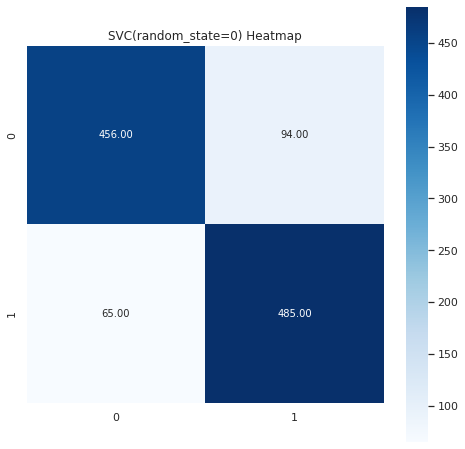

[[460  90]
 [ 65 485]]
Recall for LogisticRegression(random_state=0) : 0.8818181818181818
Precision for LogisticRegression(random_state=0) : 0.8434782608695652
F1 Score for LogisticRegression(random_state=0) : 0.8622222222222222


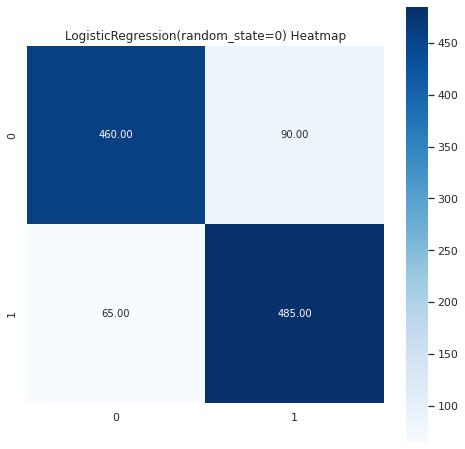

[[455  95]
 [ 81 469]]
Recall for MLPClassifier(random_state=0) : 0.8527272727272728
Precision for MLPClassifier(random_state=0) : 0.8315602836879432
F1 Score for MLPClassifier(random_state=0) : 0.8420107719928187


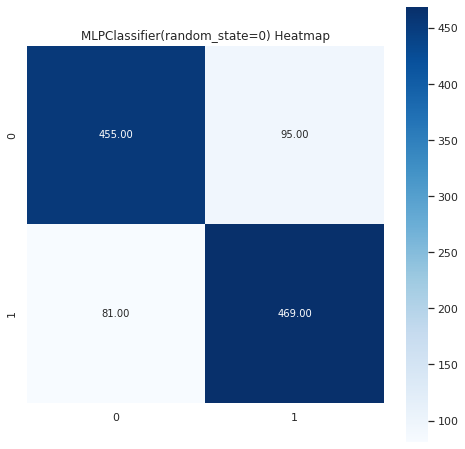

In [26]:

def conf_mat():
    for i in range(0,4):
        cm = confusion_matrix(n_test,models_test_pred[i])
        tn, fp, fn, tp  = confusion_matrix(n_test,models_test_pred[i]).ravel()
        print(cm)
        recall = tp/(tp+fn)
        precision = tp/(tp+fp)
        f1_score = 2*(precision*recall)/(precision+recall)
        print("Recall for",models[i],":",recall)
        print("Precision for",models[i],":",precision)
        print("F1 Score for",models[i],":",f1_score)
        
        # Heatmap
        
        plt.figure(figsize=(8, 8))
        sns.set()
        sns.heatmap(cm, cbar=True, square=True, annot=True, fmt='.2f', annot_kws={'size': 10}, cmap="Blues")
        plt.title(str(models[i])+" Heatmap")
        plt.show()
    
conf_mat()



# Hyperparameter Tuning

In [27]:
param_grid1 = {"n_estimators":[20,40,60,80],"max_depth":list(range(2,10))}
param_grid2 = {"kernel":["linear","rbf","poly","sigmoid"],"degree":[2,3,4],"C":[0.5,1,10]}
param_grid3 = {"C":[0.5,1,10]}
param_grid4 = {"hidden_layer_sizes": [(10,30,10),(20,)],"alpha": [0.0001, 0.05],'max_iter':[500,1000],
                "learning_rate": ['constant','adaptive'],"activation": ['relu','softmax','tanh']}

p_grid = {0:param_grid1,1:param_grid2,2:param_grid3,3:param_grid4}
gp_grid = [param_grid1,param_grid2,param_grid3,param_grid4]

* RandomizedSearchCV

In [28]:
def h_tuning():
    for k in range(0,4):
        rscv = RandomizedSearchCV(models[k],param_distributions=p_grid[k],cv=5,n_jobs=-1)
        rscv.fit(m_train,n_train)
        print(models[k],"best parameters are:",rscv.best_params_)
        print(models[k],"best score are:",rscv.best_score_)
#         gscv = GridSearchCV(models[k],param_grid=p_grid[k],cv=5,n_jobs=-1,verbose = 0,return_train_score=True)
#         gscv.fit(m_train,n_train)
#         print(models[k],"best parameters are:",gscv.best_params_)
#         print(models[k],"best score are:",gscv.best_score_)

h_tuning()

RandomForestClassifier(random_state=0) best parameters are: {'n_estimators': 60, 'max_depth': 8}
RandomForestClassifier(random_state=0) best score are: 0.8094871794871794
SVC(random_state=0) best parameters are: {'kernel': 'rbf', 'degree': 3, 'C': 10}
SVC(random_state=0) best score are: 0.8617948717948718
LogisticRegression(random_state=0) best parameters are: {'C': 10}
LogisticRegression(random_state=0) best score are: 0.8612820512820513
MLPClassifier(random_state=0) best parameters are: {'max_iter': 1000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (20,), 'alpha': 0.05, 'activation': 'relu'}
MLPClassifier(random_state=0) best score are: 0.8543589743589743


* Prediction using SVC model(ml model with highest best score)

In [29]:
df1 = pd.read_csv("/content/drive/MyDrive/IMDB Movie Reviews/IMDB Dataset.csv")
inp = df1.iloc[6666,]

# Final ML Model
clf = SVC(kernel='rbf',degree=2,C=10,random_state=0)
clf.fit(m_train, n_train)

inp["review"] = stemming(inp["review"])
ip=[inp["review"]]
# Vectorize 
ip = vectorizer.transform(ip)

# Check Prediction
actual_val = inp["sentiment"]
# print("Actual Value:"actual_val)
pred = clf.predict(ip)
# print("Prediction:"pred[0])
if actual_val == ma[pred[0]]:
    print("Accurate Prediction")
    print("Sentiment of the input review is",ma[pred[0]])
else:
    print("Wrong Prediction")


Accurate Prediction
Sentiment of the input review is positive
